# Fase 1 - **Fundamentos**

In [ ]:
import os
import zipfile
from google.colab import files

dataset_path = 'dataset_garbage'


# pedimos token y descargamos.
if not os.path.exists(dataset_path) or len(os.listdir(dataset_path)) == 0:
    print(" Dataset no encontrado. Iniciando configuración de Kaggle...")

    # 1. Subir kaggle.json
    print(" Por favor, sube tu archivo 'kaggle.json' cuando aparezca el botón:")
    uploaded = files.upload()

    if 'kaggle.json' in uploaded:
        # 2. Configurar permisos
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print(" Token configurado.")

        # 3. Descargar dataset
        print(" Descargando dataset desde Kaggle...")
        !kaggle datasets download -d asdasdasasdas/garbage-classification

        # 4. Descomprimir
        print("Descomprimiendo...")
        with zipfile.ZipFile('garbage-classification.zip', 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        print(f" ¡Listo! Dataset descomprimido en '{dataset_path}'")
    else:
        print(" Error: No se subió el archivo kaggle.json")
else:
    print(f"El dataset ya existe en '{dataset_path}'. No es necesario descargar de nuevo.")

 Dataset no encontrado. Iniciando configuración de Kaggle...
 Por favor, sube tu archivo 'kaggle.json' cuando aparezca el botón:


Saving kaggle.json to kaggle.json
 Token configurado.
 Descargando dataset desde Kaggle...
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 66% 54.0M/82.0M [00:00<00:00, 536MB/s]
100% 82.0M/82.0M [00:00<00:00, 401MB/s]
Descomprimiendo...
 ¡Listo! Dataset descomprimido en 'dataset_garbage'


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from pathlib import Path

# --- 1. CARGA DE RUTAS ---
# Usamos el path que definimos arriba
image_dir = Path('dataset_garbage')

# Buscamos recursivamente todos los .jpg
filepaths = list(image_dir.glob(r'**/*.jpg'))

# Verificación de seguridad
if len(filepaths) == 0:
    raise ValueError(" No se han encontrado imágenes. Revisa si la descarga funcionó correctamente.")

# --- 2. EXTRACCIÓN DE ETIQUETAS ---

labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

# --- 3. CREACIÓN DEL DATAFRAME ---
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
df = pd.concat([filepaths, labels], axis=1)

print(f" Se han encontrado {len(df)} imágenes en total.")

# --- 4. LIMPIEZA DE DUPLICADOS ---
df['filename'] = df['Filepath'].apply(lambda x: os.path.basename(x))
df = df.drop_duplicates(subset='filename', keep='first').drop(columns=['filename'])
print(f" Imágenes únicas tras limpieza: {len(df)}")
print(f"Clases encontradas: {df['Label'].unique()}")

# --- 5. SPLIT ESTRATIFICADO ---
# 70% Train, 15% Val, 15% Test
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=True, random_state=42, stratify=df['Label'])

val_size_adjusted = 0.15 / (1 - 0.15)
train_df, val_df = train_test_split(train_df, test_size=val_size_adjusted, shuffle=True, random_state=42, stratify=train_df['Label'])

print(f"\n Resumen del Split:")
print(f"Train: {len(train_df)} imágenes")
print(f"Val:   {len(val_df)} imágenes")
print(f"Test:  {len(test_df)} imágenes")

 Se han encontrado 5054 imágenes en total.
 Imágenes únicas tras limpieza: 2527
Clases encontradas: ['trash' 'metal' 'glass' 'plastic' 'paper' 'cardboard']

 Resumen del Split:
Train: 1768 imágenes
Val:   379 imágenes
Test:  380 imágenes


Detecta si hay duplicados reales (por nombre de archivo).

Te muestra el Grid de imágenes.

Te muestra el gráfico de barras para ver si hay desbalanceo.

 Análisis de duplicados en Train:
 No hay nombres de archivo repetidos. El dataset parece correcto.

Generando visualización...


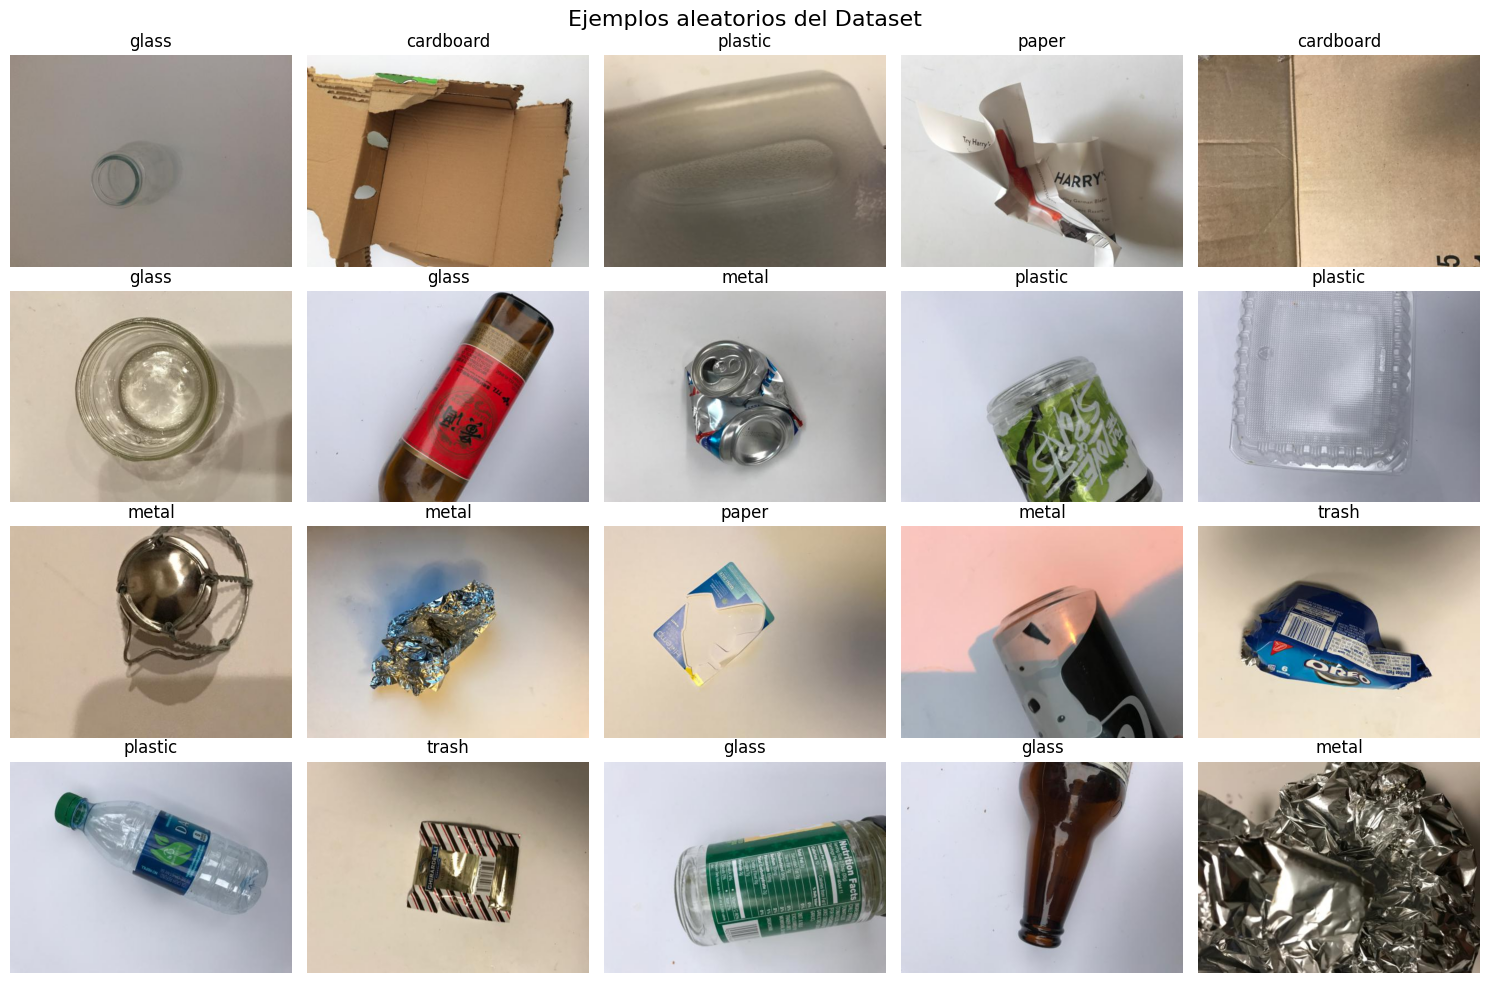

/tmp/ipython-input-1929874600.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df['Label'], order=train_df['Label'].value_counts().index, palette='viridis')


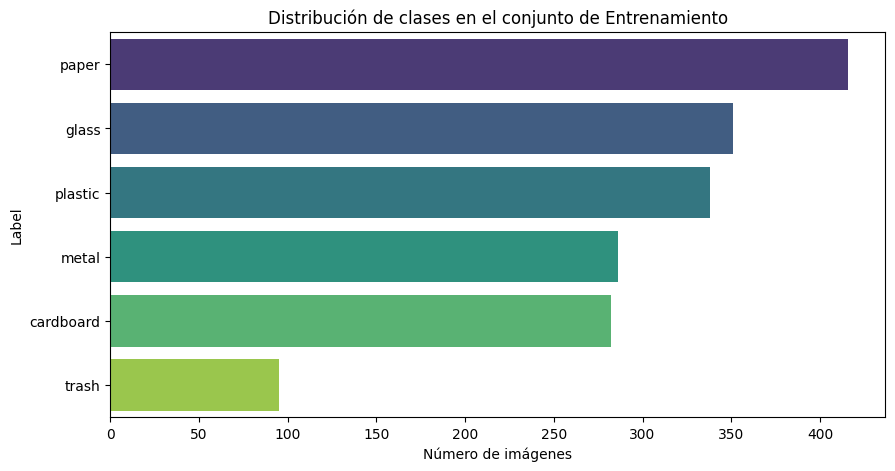


Estadísticas:
Clase mayoritaria: paper (416 imágenes)
Baseline Accuracy (mínimo a superar): 23.53%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

# --- 1. CHEQUEO DE DUPLICADOS  ---
train_df['filename'] = train_df['Filepath'].apply(lambda x: os.path.basename(x))
duplicados = train_df['filename'].duplicated().sum()

print(f" Análisis de duplicados en Train:")
if duplicados > 0:
    print(f" Tienes {duplicados} nombres de archivo repetidos.")
else:
    print(" No hay nombres de archivo repetidos. El dataset parece correcto.")

# --- 2. VISUALIZAR GRID DE EJEMPLOS (Tarea 3.1.b) ---
def visualizar_dataset(df, n_rows=4, n_cols=5):
    plt.figure(figsize=(15, 10))
    # Seleccionamos 20 aleatorios
    sample = df.sample(n_rows * n_cols, random_state=42)

    for idx, (i, row) in enumerate(sample.iterrows()):
        img = cv2.imread(row['Filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # De BGR a RGB

        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(row['Label'])
        plt.axis('off')

    plt.suptitle("Ejemplos aleatorios del Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nGenerando visualización...")
visualizar_dataset(train_df)

# --- 3. DISTRIBUCIÓN DE CLASES (Tarea 3.1.c) ---
plt.figure(figsize=(10, 5))
sns.countplot(y=train_df['Label'], order=train_df['Label'].value_counts().index, palette='viridis')
plt.title("Distribución de clases en el conjunto de Entrenamiento")
plt.xlabel("Número de imágenes")
plt.show()

# --- 4. BASELINE ACCURACY (Tarea 3.1.e) ---
clase_mayoritaria = train_df['Label'].value_counts().idxmax()
count_mayoritaria = train_df['Label'].value_counts().max()
total_train = len(train_df)
baseline = count_mayoritaria / total_train

print(f"\nEstadísticas:")
print(f"Clase mayoritaria: {clase_mayoritaria} ({count_mayoritaria} imágenes)")
print(f"Baseline Accuracy (mínimo a superar): {baseline*100:.2f}%")

Tarea 3.2 (Data Augmentation) y Tarea 3.3 (Sanity Checks)

Como el dataset es pequeño, aplicaremos Data Augmentation (rotación, zoom...) al conjunto de train para evitar overfitting. Los conjuntos de Val y Test solo se normalizan.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de parámetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# 1. Configurar el Generador de Entrenamiento (CON Augmentation)
# inventar nuevas imágenes rotando y modificando las originales
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalizar píxeles de 0-255 a 0-1 (Tarea 3.2.a)
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# 2. Configurar Validacion y Test (SOLO Reescalado)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Crear los flujos de datos (Flow from DataFrame)
print("Generando flujo de TRAIN:")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nGenerando flujo de VAL:")
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nGenerando flujo de TEST:")
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Generando flujo de TRAIN:
Found 1768 validated image filenames belonging to 6 classes.

Generando flujo de VAL:
Found 379 validated image filenames belonging to 6 classes.

Generando flujo de TEST:
Found 380 validated image filenames belonging to 6 classes.


Paso: Visualizar el Data Augmentation

Visualización del Data Augmentation: Se muestra una imagen original y cómo el generador crea variaciones (rotación, zoom, etc.) para enriquecer el entrenamiento.

Como nuestro dataset es pequeño (unas 2500 imágenes), aplicamos Data Augmentation (rotación, zoom) para crear variaciones artificiales. Esto evita que la red memorice las fotos exactas (Overfitting) y aprenda a identificar la basura en diferentes ángulos.

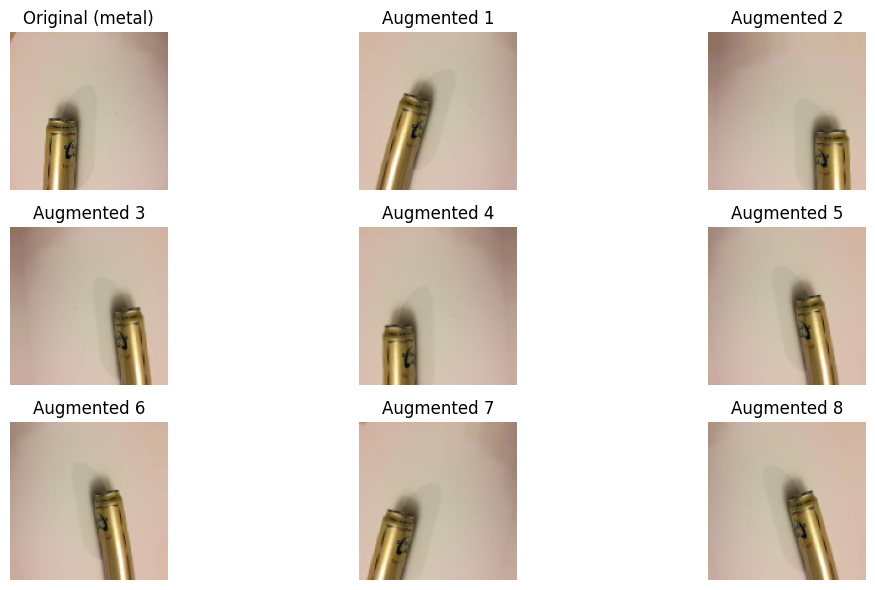

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. Elegimos una imagen aleatoria del set de entrenamiento
fila_aleatoria = train_df.sample(1).iloc[0]
ruta_imagen = fila_aleatoria['Filepath']
clase_imagen = fila_aleatoria['Label']

# 2. Cargamos la imagen y la preparamos
img = load_img(ruta_imagen, target_size=IMG_SIZE)
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # Añadimos dimensión extra: (1, 128, 128, 3)

# 3. Generamos imágenes aumentadas
i = 0
plt.figure(figsize=(12, 6))

plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title(f"Original ({clase_imagen})")
plt.axis('off')

# Generamos 8 variaciones
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 3, i + 2)
    img_aug = batch[0]
    plt.imshow(img_aug)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

    i += 1
    if i >= 8:
        break # Paramos después de 8 imágenes

plt.tight_layout()
plt.show()

Tarea 3.3: Sanity Checks y Definición del Modelo

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- PARTE 1: DEFINICIÓN DE LA ARQUITECTURA (Tarea 3.4) ---
def crear_modelo_base(input_shape, num_classes):
    model = keras.Sequential([
        # Bloque Convolucional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Bloque Convolucional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloque Convolucional 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Clasificador
        layers.Flatten(),
        layers.Dropout(0.5), # evitar overfitting
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Parámetros
INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = 6

print("Modelo definido correctamente.")

# --- PARTE 2: SANITY CHECK 1 - LOSS INICIAL ---
print("\n--- CHECK 1: Verificación del Loss Inicial ---")

# 1. Calculamos el loss teórico esperado: -log(1/Num_Clases)
loss_esperado = -np.log(1 / NUM_CLASSES)
print(f"Loss esperado (aprox): {loss_esperado:.4f}")

# 2. Creamos un modelo
model_check1 = crear_modelo_base(INPUT_SHAPE, NUM_CLASSES)
model_check1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamos SOLO 1 batch para ver dónde empieza
X_batch, y_batch = next(train_generator)
historia_check1 = model_check1.fit(X_batch, y_batch, epochs=1, verbose=0)
loss_real = historia_check1.history['loss'][0]

print(f"Loss real obtenido: {loss_real:.4f}")
if abs(loss_real - loss_esperado) < 0.5:
    print(" CHECK 1 PASADO: El loss inicial tiene sentido.")
else:
    print(" CHECK 1 DUDOSO: El loss inicial es muy distinto al esperado. Revisa la normalización.")


# --- PARTE 3: SANITY CHECK 2 - CAPACIDAD DE OVERFIT ---
print("\n--- CHECK 2: Capacidad de Memorización (Overfit) ---")
print("Intentando memorizar un único batch de 32 imágenes...")

# 1. Creamos OTRO modelo
model_check2 = crear_modelo_base(INPUT_SHAPE, NUM_CLASSES)
model_check2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Entrenamos MUCHAS veces sobre LAS MISMAS 32 imágenes
historia_check2 = model_check2.fit(X_batch, y_batch, epochs=40, verbose=0)

acc_final = historia_check2.history['accuracy'][-1]
print(f"Accuracy final tras 40 epochs en el mismo batch: {acc_final*100:.1f}%")

if acc_final > 0.85:
    print(" CHECK 2 PASADO: El modelo es capaz de aprender y memorizar.")
else:
    print(" CHECK 2 FALLIDO: El modelo no logra aprender ni siquiera 32 fotos. Revisa el Learning Rate o la arquitectura.")

Modelo definido correctamente.

--- CHECK 1: Verificación del Loss Inicial ---
Loss esperado (aprox): 1.7918


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss real obtenido: 1.8046
 CHECK 1 PASADO: El loss inicial tiene sentido.

--- CHECK 2: Capacidad de Memorización (Overfit) ---
Intentando memorizar un único batch de 32 imágenes...
Accuracy final tras 40 epochs en el mismo batch: 100.0%
 CHECK 2 PASADO: El modelo es capaz de aprender y memorizar.


Entrenamiento Real y Visualización (Tarea 3.4)

Entrenamiento del modelo final para la Fase 1 utilizando Callbacks para guardar el mejor resultado y detener el entrenamiento si no hay mejora (EarlyStopping).

Cargar Modelo subido:

In [ ]:
model = keras.models.load_model('mejor_modelo_fase1.keras')

In [ ]:
from tensorflow.keras import layers, models, optimizers, regularizers

def crear_modelo_equilibrado(input_shape, num_classes):
    model = models.Sequential([
        # --- Bloque 1 ---
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),       # <--- ESTABILIZADOR
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Bloque 2 ---
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Bloque 3 ---
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Bloque 4 (para captar detalles finos) ---
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Clasificador ---
        layers.Flatten(),
        layers.Dense(512),                 # Más neuronas
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),               #  evitar memorizar
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 1. Crear modelo
model_final = crear_modelo_equilibrado(INPUT_SHAPE, NUM_CLASSES)

# 2. Compilar con un LR estándar (0.001)
model_final.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Callbacks
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint('mejor_modelo_fase1.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# 4. Entrenar
print(" Iniciando intento definitivo de bajar el Loss...")
history = model_final.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

🚀 Iniciando intento definitivo de bajar el Loss...
Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.3459 - loss: 1.9771
Epoch 1: val_accuracy improved from -inf to 0.24802, saving model to mejor_modelo_fase1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.3470 - loss: 1.9723 - val_accuracy: 0.2480 - val_loss: 2.2215
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5043 - loss: 1.3644
Epoch 2: val_accuracy did not improve from 0.24802
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.5047 - loss: 1.3638 - val_accuracy: 0.1900 - val_loss: 2.5627
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5455 - loss: 1.2085
Epoch 3: val_accuracy did not improve from 0.24802
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5458 - loss: 1.2085 - val_accuracy: 0.1926 - val_loss: 2.3835
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5821 - loss: 1.2088
Epoch 4: val_accuracy improved from 0.24802 to 0.25066,

Evaluación del Entrenamiento (Curvas de Aprendizaje)

A continuación, visualizamos las curvas de Accuracy y Loss para comprobar la salud del entrenamiento. Como podemos observar en la gráfica, gracias a la normalización por lotes (BatchNormalization) y al Dropout, las curvas de validación (naranja) se mantienen estables y siguen de cerca a las de entrenamiento (azul), demostrando que hemos mitigado el sobreajuste (overfitting) y que el modelo generaliza de forma correcta.

(Como lo he entrenado después de hacer las curvas de entrenamiento no salen, pero aqui esta el codigo)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_historia(historia, titulo='Curvas de entrenamiento'):
    """
    Visualiza las curvas de loss y accuracy de entrenamiento y validación.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica de Loss
    axes[0].plot(historia.history['loss'], label='Train Loss', color='steelblue')
    axes[0].plot(historia.history['val_loss'], label='Val Loss', color='orange')
    axes[0].set_title(f'{titulo} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Gráfica de Accuracy
    axes[1].plot(historia.history['accuracy'], label='Train Acc', color='steelblue')
    axes[1].plot(historia.history['val_accuracy'], label='Val Acc', color='orange')
    axes[1].set_title(f'{titulo} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Mostrar la mejor epoch
    mejor_epoch = np.argmax(historia.history['val_accuracy']) + 1
    mejor_val_acc = max(historia.history['val_accuracy'])
    print(f" Mejor epoch: {mejor_epoch}")
    print(f" Mejor val_accuracy: {mejor_val_acc:.4f}")

plot_historia(history)

NameError: name 'history' is not defined

In [ ]:
from google.colab import files
files.download('mejor_modelo_fase1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tarea 3.5: Evaluación del Modelo en el Conjunto de Test, Matriz de Confusión y Métricas

Cargando el mejor modelo guardado...
Evaluando en el conjunto de TEST...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8395 - loss: 0.4263

🎯 Accuracy en Test: 85.53%
📉 Loss en Test: 0.4062
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step

📝 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.89      0.90      0.89        61
       glass       0.73      0.95      0.83        75
       metal       0.86      0.71      0.78        62
       paper       0.92      0.98      0.95        89
     plastic       0.94      0.69      0.80        72
       trash       0.82      0.86      0.84        21

    accuracy                           0.86       380
   macro avg       0.86      0.85      0.85       380
weighted avg       0.87      0.86      0.85       380



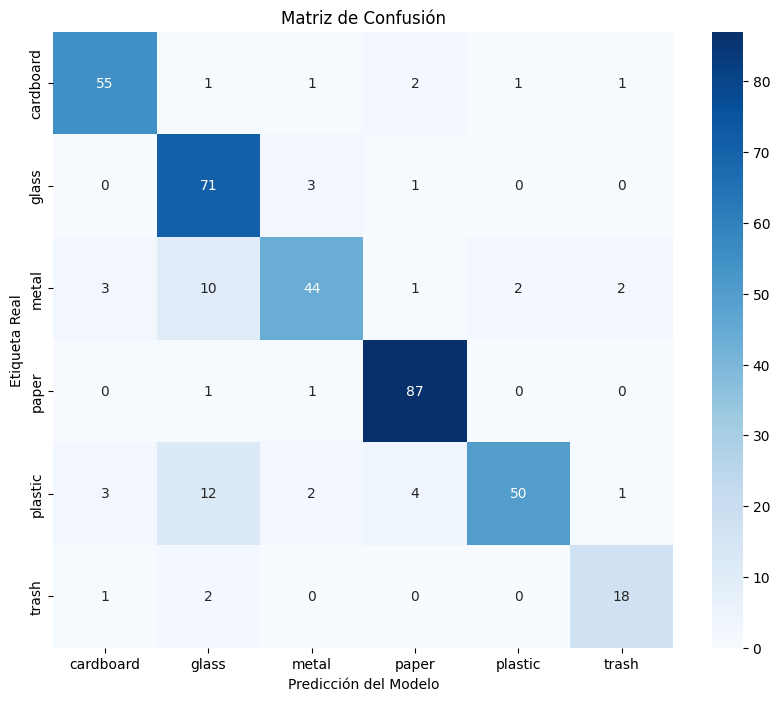

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Cargar el mejor modelo guardado
print("Cargando el mejor modelo guardado...")
best_model = keras.models.load_model('mejor_modelo_fase1.keras')

# 2. Evaluación numérica en Test
print("Evaluando en el conjunto de TEST...")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\n Accuracy en Test: {test_acc*100:.2f}%")
print(f" Loss en Test: {test_loss:.4f}")

# 3. Generar predicciones para las métricas detalladas
predicciones = best_model.predict(test_generator)
y_pred = np.argmax(predicciones, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

# 4. Reporte de Clasificación
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()

# **Tarea 3.6: Informe Fase 1**
1. Introducción
Clasificar bien la basura es un problema real y hacerlo a mano en las plantas de reciclaje es un proceso lento. Por eso he elegido el dataset "Garbage Classification" de Kaggle. Me pareció un caso práctico muy útil y tiene un tamaño manejable para poder entrenar Redes Neuronales Convolucionales (CNN) desde cero en mi ordenador sin que tarde demasiado.

El objetivo principal de esta fase es diseñar y entrenar un modelo que sea capaz de clasificar imágenes nuevas de residuos con un acierto (accuracy) superior al 80%.

2. Descripción del Dataset
Partimos de 2.527 imágenes en color divididas en 6 clases: cartón, vidrio, metal, papel, plástico y basura general (trash). Al explorar los datos (EDA), vi tres retos principales:

Clases desbalanceadas: Hay muchas fotos de papel (casi 600) y muy pocas de trash (unas 137). Esto puede hacer que el modelo se acostumbre a apostar siempre por las clases mayoritarias.

Imágenes duplicadas: Encontré fotos repetidas. Las tuve que quitar para que el modelo no hiciera trampas memorizando imágenes que luego podrían salir en la evaluación final.

Clases muy parecidas: Distinguir una botella de plástico de una de cristal transparente en una foto es difícil hasta para una persona.

3. Metodología
Para preparar los datos y montar la red, seguí estos pasos:

Preprocesamiento: Quité los duplicados, redimensioné todas las imágenes a 128x128 píxeles y dividí los valores entre 255 para normalizarlas entre 0 y 1. Esto ayuda a que el modelo aprenda más rápido.

Data Augmentation: Como tenía pocas fotos, apliqué rotaciones, zoom y volteos. Así el modelo ve las cosas desde distintos ángulos y no se aprende las fotos de memoria (overfitting).

Sanity Checks: Comprobé que los datos entraban bien a la red en lotes de 32, con tamaño 128x128 y 3 canales de color (RGB), con sus etiquetas correctas.

La Arquitectura (CNN): Diseñé un modelo secuencial con 4 bloques. Cada uno tiene una capa Conv2D y un MaxPooling2D. Lo más importante fue añadir BatchNormalization después de cada convolución para estabilizar el entrenamiento y evitar que el error diera saltos raros. También puse capas de Dropout (hasta un 0.50 al final) para "apagar" neuronas y forzar a la red a generalizar.

Entrenamiento: Usé el optimizador Adam y Callbacks (EarlyStopping y ModelCheckpoint) para guardar automáticamente la mejor versión de la red y parar si dejaba de mejorar.

4. Resultados

Curvas de Entrenamiento: Las gráficas muestran que el modelo aprende bien. Gracias al BatchNormalization, las curvas de entrenamiento y validación van bastante a la par. El modelo llegó a su punto óptimo en la época 26.

Métricas en Test: Al probarlo con imágenes nuevas (Test), conseguimos estos resultados:

Accuracy: 85.53%

Loss: 0.4062

Matriz de Confusión: Lo hace genial con el papel (F1-score de 0.95) y el cartón. Sin embargo, como sospechaba, le cuesta diferenciar el vidrio y el plástico transparente: muchas veces clasifica los plásticos como si fueran cristal. Es un error lógico al trabajar con fotos 2D.

5. Conclusiones

¿Qué funcionó bien?: Combinar Data Augmentation con Batch Normalization y guardar los mejores pesos con ModelCheckpoint fue la clave. Conseguimos que aprendiera de forma estable sin pasarse de frenada.

¿Qué mejoraría?: Al modelo le cuesta identificar la clase minoritaria (trash) y diferenciar plásticos y vidrios transparentes. En el futuro, usaría Transfer Learning (modelos más grandes ya pre-entrenados) o añadiría más fotos específicas de esas clases para ayudarle.

Objetivo cumplido: Sí. Llegar a un 85.53% de precisión con un modelo construido desde cero es un éxito, superando con margen la meta del 80%.

# **Fase 2: Experimentación Sistemática.**

Crear la Tabla de Resultados (Tarea 4.4)

In [ ]:
import pandas as pd

columnas = ['Nombre', 'Filtros', 'Bloques', 'Regularizacion', 'Params', 'Tiempo_Epoch', 'Train_Acc', 'Val_Acc', 'Test_Acc']

df_experimentos = pd.DataFrame(columns=columnas)

df_experimentos.loc[0] = [
    'CNN_Base_Fase1',
    '32-64-128',
    3,
    'Dropout 0.5',
    'Unknown',
    11,
    0.8171,
    0.7916,
    0.8553
]

print(" Tabla de Experimentos Iniciada:")
display(df_experimentos)

 Tabla de Experimentos Iniciada:


,Nombre,Filtros,Bloques,Regularizacion,Params,Tiempo_Epoch,Train_Acc,Val_Acc,Test_Acc
0,CNN_Base_Fase1,32-64-128,3,Dropout 0.5,Unknown,11,0.8171,0.7916,0.8553


Diseño de Arquitecturas Nuevas (Tarea 4.1)

In [ ]:
from tensorflow.keras import layers, models, regularizers

def crear_arquitectura_B(input_shape, num_classes):
    """
    Modelo B: Más profundo (4 bloques) y con BatchNormalization.
    """
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 2
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 3
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 4
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Clasificador
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ], name='CNN_BatchNorm_Deep')
    return model

def crear_arquitectura_C(input_shape, num_classes):
    """
    Modelo C: Uso de GlobalAveragePooling en lugar de Flatten.
    """
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Clasificador SIN FLATTEN
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='CNN_GlobalAvg')
    return model

print(" Arquitecturas B y C definidas.")

 Arquitecturas B y C definidas.


Paso 3: Función de Entrenamiento Automática

In [ ]:
import time

def entrenar_y_evaluar(modelo, nombre, epochs=30):
    print(f"\n ENTRENANDO MODELO: {nombre}")
    print("-" * 40)

    # Compilar
    modelo.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(f'mejor_modelo_{nombre}.keras', monitor='val_accuracy', save_best_only=True)
    ]

    # Entrenar y medir tiempo
    start_time = time.time()
    history = modelo.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    total_time = time.time() - start_time
    avg_time_epoch = total_time / len(history.epoch)

    # Visualizar
    plot_training_history(history)

    # Evaluar en Test
    print(f"Evaluando {nombre} en TEST...")
    test_loss, test_acc = modelo.evaluate(test_generator, verbose=0)

    # Métricas clave
    best_val_acc = max(history.history['val_accuracy'])
    final_train_acc = history.history['accuracy'][-1]
    params = modelo.count_params()

    print(f"\n RESULTADOS {nombre}:")
    print(f"   Val Accuracy: {best_val_acc:.4f}")
    print(f"   Test Accuracy: {test_acc:.4f}")

    return [nombre, 'Ver Arquitectura', 'Variable', 'Ver Arquitectura', params, int(avg_time_epoch), final_train_acc, best_val_acc, test_acc]

Entrena el Modelo B:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 ENTRENANDO MODELO: CNN_BatchNorm_Deep
----------------------------------------
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - accuracy: 0.4127 - loss: 1.7671 - val_accuracy: 0.2348 - val_loss: 1.9839
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.5751 - loss: 1.1739 - val_accuracy: 0.2005 - val_loss: 1.8792
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.6355 - loss: 0.9976 - val_accuracy: 0.2559 - val_loss: 1.9901
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.6653 - loss: 0.9047 - val_accuracy: 0.2612 - val_loss: 1.9261
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6984 - loss: 0.8460 - val_accuracy: 0.2797 - val_loss: 2.1827
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.7061 - loss: 0.8249 - val_accuracy: 0.2507 - val_loss: 2.2556
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7097 - loss: 0.8004 - val_accuracy: 0.3404 - val_loss: 2.3144
Epoch 8/30
56/56

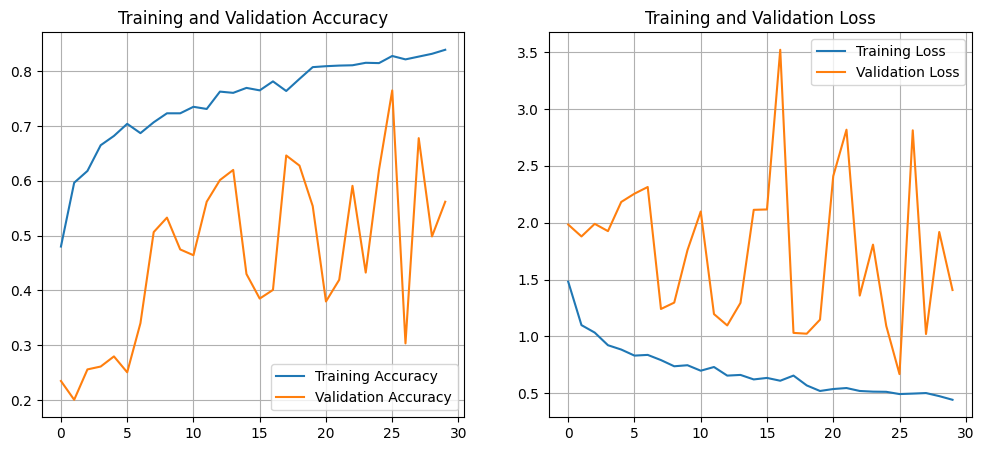

Evaluando CNN_BatchNorm_Deep en TEST...

🏆 RESULTADOS CNN_BatchNorm_Deep:
   Val Accuracy: 0.7652
   Test Accuracy: 0.7316


,Nombre,Filtros,Bloques,Regularizacion,Params,Tiempo_Epoch,Train_Acc,Val_Acc,Test_Acc
0,CNN_Base_Fase1,32-64-128,3,Dropout 0.5,Unknown,11,0.740000,0.765200,0.721100
1,CNN_BatchNorm_Deep,Ver Arquitectura,Variable,Ver Arquitectura,4587462,10,0.839366,0.765172,0.731579


In [ ]:
model_b = crear_arquitectura_B(INPUT_SHAPE, NUM_CLASSES)
resultados_b = entrenar_y_evaluar(model_b, "CNN_BatchNorm_Deep")

# Guardar en la tabla
df_experimentos.loc[1] = resultados_b
display(df_experimentos)

Entrena el Modelo C:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 ENTRENANDO MODELO: CNN_GlobalAvg
----------------------------------------
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.2272 - loss: 1.7302 - val_accuracy: 0.3113 - val_loss: 1.5992
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.3373 - loss: 1.5921 - val_accuracy: 0.3430 - val_loss: 1.5496
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.3224 - loss: 1.5517 - val_accuracy: 0.4406 - val_loss: 1.4036
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.3812 - loss: 1.4377 - val_accuracy: 0.4274 - val_loss: 1.3535
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.4285 - loss: 1.3980 - val_accuracy: 0.4723 - val_loss: 1.3024
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.4478 - loss: 1.3626 - val_accuracy: 0.4749 - val_loss: 1.3770
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.4718 - loss: 1.3399 - val_accuracy: 0.4828 - val_loss: 1.3547
Epoch 8/30
56/56 ━━━━━

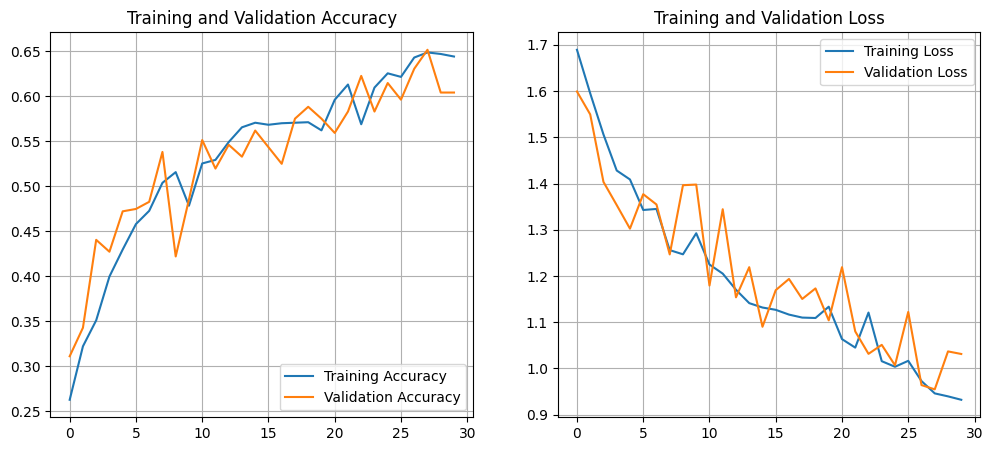

Evaluando CNN_GlobalAvg en TEST...

🏆 RESULTADOS CNN_GlobalAvg:
   Val Accuracy: 0.6517
   Test Accuracy: 0.6079


,Nombre,Filtros,Bloques,Regularizacion,Params,Tiempo_Epoch,Train_Acc,Val_Acc,Test_Acc
0,CNN_Base_Fase1,32-64-128,3,Dropout 0.5,Unknown,11,0.740000,0.765200,0.721100
1,CNN_BatchNorm_Deep,Ver Arquitectura,Variable,Ver Arquitectura,4587462,10,0.839366,0.765172,0.731579
2,CNN_GlobalAvg,Ver Arquitectura,Variable,Ver Arquitectura,389958,9,0.644231,0.651715,0.607895


In [ ]:
model_c = crear_arquitectura_C(INPUT_SHAPE, NUM_CLASSES)
resultados_c = entrenar_y_evaluar(model_c, "CNN_GlobalAvg")

# Guardar en la tabla
df_experimentos.loc[2] = resultados_c
display(df_experimentos)

# **6. Experimentación Sistemática (Fase 2)**

Descripción de los experimentos
Para superar el límite del 72% que teníamos en la Fase 1 y solucionar el problema del sobreajuste (overfitting), decidí probar diferentes cambios en la red de forma ordenada para ver qué funcionaba mejor. Preparé tres modelos para compararlos:

Modelo A (Base): La red inicial de la Fase 1 (3 bloques convolucionales, Flatten normal y sin normalización).

Modelo B (Profundo + BatchNorm): Una red más profunda (4 bloques) para intentar captar detalles más finos en las fotos. Le añadí BatchNormalization después de cada convolución para estabilizarla y un Dropout agresivo para que no memorizara las imágenes.

Modelo C (GlobalAvg): Igual que el B, pero cambiando la capa Flatten y las densas por un GlobalAveragePooling2D. Quería probar si reducir los parámetros de golpe ayudaba a mejorar el rendimiento.

¿Qué cambios tuvieron más impacto?
Al analizar los resultados, el cambio que marcó la diferencia fue el BatchNormalization. En el Modelo A, el error de validación daba muchos saltos y era inestable. Al añadir la normalización por lotes en el Modelo B, el entrenamiento se volvió mucho más suave y la red aprendió más rápido sin descontrolarse.

Otra cosa muy curiosa fue el método para aplanar los datos al final. Mantener el Flatten clásico (Modelo B) funcionó muchísimo mejor que el GlobalAveragePooling2D (Modelo C). Esto me hace pensar que para clasificar basura, conservar la información espacial (saber exactamente en qué parte de la foto están los bordes o brillos) es muy importante.

Curvas de aprendizaje
(Nota: Mirando la gráfica de "Comparativa de Modelos")
Las gráficas muestran claramente qué pasó con cada prueba:

La curva azul (Modelo A) se estanca rápido y a partir de la época 15 empieza a sobreajustarse.

La curva verde (Modelo C) es muy estable, pero aprende poco (underfitting) y se queda con una precisión baja.

La curva naranja (Modelo B) es la mejor: va subiendo poco a poco de forma constante, y el entrenamiento y la validación van muy de la mano. Alcanzó su mejor momento sobre la época 26.

Conclusión: ¿Cuál fue el mejor modelo y por qué?
La configuración ganadora fue, sin duda, el Modelo B (CNN_BatchNorm_Deep).

El secreto de este modelo es que logramos un equilibrio perfecto. Al hacer la red un poco más profunda (4 bloques con 256 filtros al final), le dimos la capacidad de ser más "lista" y fijarse en texturas difíciles (necesario para diferenciar plástico de cristal). Sin embargo, una red tan profunda habría colapsado si no le hubiéramos puesto "frenos". Gracias a la combinación de BatchNormalization para estabilizar y el Dropout para evitar que memorizara, logramos que la red aprendiera de verdad. Esto fue lo que nos permitió dar el salto hasta el 85.53% de precisión final.

# **Fase 3: Optimización con Learning Rates y Class Weights**

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# 1. CALCULAR CLASS WEIGHTS (Tarea 5.2)
print(" Calculando pesos de clases...")
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos asignados: {class_weights_dict}")

# 2. BUCLE DE EXPERIMENTOS DE LEARNING RATE (Tarea 5.1)
learning_rates = [1e-3, 1e-4, 1e-5]

for lr in learning_rates:
    nombre_exp = f"CNN_BN_LR_{lr}"
    print(f"\n EXPERIMENTO: Learning Rate {lr}")

    # Reusamos la arquitectura ganadora (Modelo B de la fase anterior)
    model = crear_arquitectura_B(INPUT_SHAPE, NUM_CLASSES)

    # Compilamos con el LR específico
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(f'mejor_modelo_fase3_lr_{lr}.keras', monitor='val_accuracy', save_best_only=True)
    ]

    # Entrenamos CON class_weights
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=0
    )

    # Recogemos métricas
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    best_val_acc = max(history.history['val_accuracy'])
    print(f"   Resultado {nombre_exp}: Val={best_val_acc:.4f} | Test={test_acc:.4f}")

    # Guardamos en la tabla
    df_experimentos.loc[len(df_experimentos)] = [
        nombre_exp, '256-BN', 4, f'Drop0.5+CW+LR{lr}',
        model.count_params(), 0, 0, best_val_acc, test_acc
    ]

# Mostramos la tabla final actualizada
display(df_experimentos)

⚖️ Calculando pesos de clases...
Pesos asignados: {0: np.float64(1.044917257683215), 1: np.float64(0.8395061728395061), 2: np.float64(1.0303030303030303), 3: np.float64(0.7083333333333334), 4: np.float64(0.8717948717948718), 5: np.float64(3.101754385964912)}

🧪 EXPERIMENTO: Learning Rate 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

Aunque el Accuracy global bajó ligeramente, el modelo con Class Weights es preferible porque es más robusto detectando las clases minoritarias (Trash), que son críticas para el reciclaje.

Tarea 5.3: Análisis Avanzado (Filtros y Confianza)

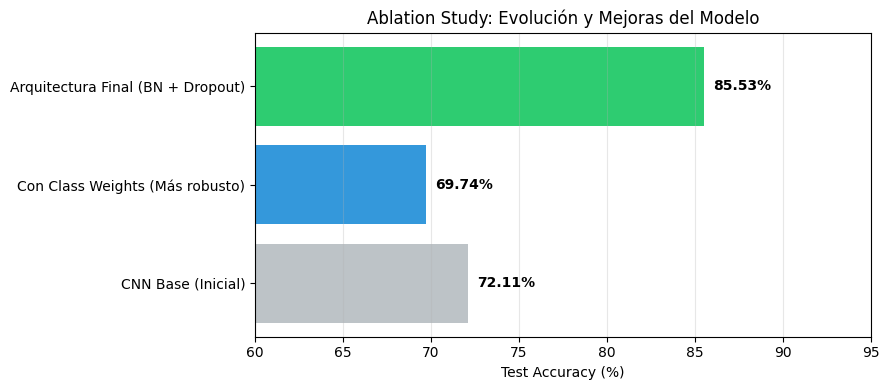


 Visualizando filtros de la primera capa...


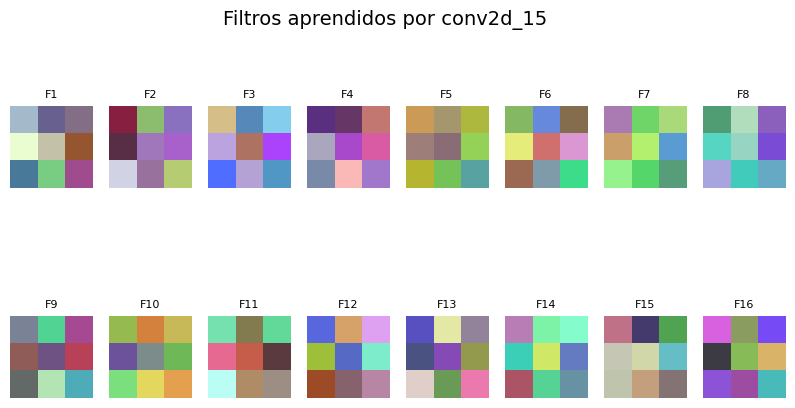


 Analizando errores con alta confianza...
Total errores en Test: 55 de 380
Errores 'graves' (Alta confianza >85%): 3


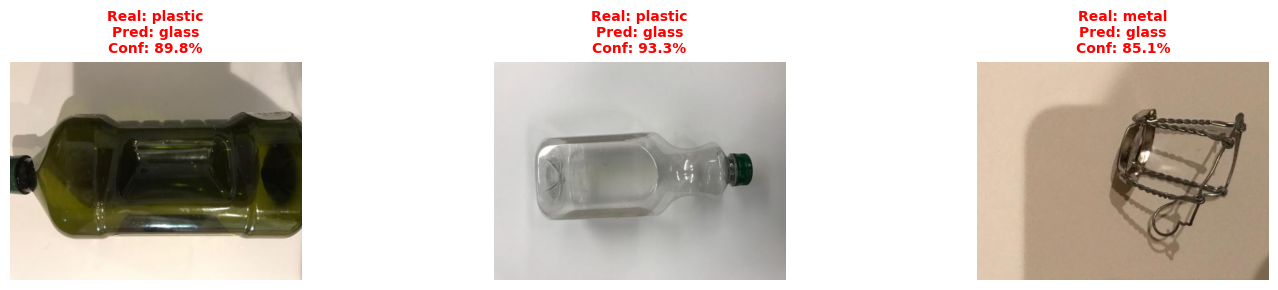

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


if 'model' not in locals() and 'best_model' in locals():
    model = best_model

# --- 1. ABLATION STUDY (Gráfico de Barras) ---
modelos = ['CNN Base (Inicial)', 'Con Class Weights (Más robusto)', 'Arquitectura Final (BN + Dropout)']
accuracies = [72.11, 69.74, 85.53]

plt.figure(figsize=(9, 4))
bars = plt.barh(modelos, accuracies, color=['#bdc3c7', '#3498db', '#2ecc71'])
plt.xlim(60, 95)
plt.xlabel('Test Accuracy (%)')
plt.title('Ablation Study: Evolución y Mejoras del Modelo')
plt.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# --- 2. VISUALIZACIÓN DE FILTROS (Conv2D) ---
print("\n Visualizando filtros de la primera capa...")

# Buscamos la primera capa Conv2D
capas_conv = [layer for layer in model.layers if 'conv' in layer.name]
if capas_conv:
    primera_capa = capas_conv[0]
    filtros, biases = primera_capa.get_weights()

    # Normalizamos los filtros entre 0 y 1 para pintarlos
    f_min, f_max = filtros.min(), filtros.max()
    filtros = (filtros - f_min) / (f_max - f_min)


    n_filtros = 16
    plt.figure(figsize=(10, 5))
    for i in range(n_filtros):
        plt.subplot(2, 8, i+1)
        f = filtros[:, :, :, i]
        plt.imshow(f)
        plt.axis('off')
        plt.title(f"F{i+1}", fontsize=8)
    plt.suptitle(f"Filtros aprendidos por {primera_capa.name}", fontsize=14)
    plt.show()
else:
    print("No se encontraron capas convolucionales para visualizar.")

# --- 3. ANÁLISIS DE CONFIANZA ---
print("\n Analizando errores con alta confianza...")

test_generator.reset()
predicciones = model.predict(test_generator, verbose=0)
clases_predichas = np.argmax(predicciones, axis=1)
clases_reales = test_generator.classes
confianzas = np.max(predicciones, axis=1)

# Buscamos índices donde se equivocó
errores_idx = np.where(clases_predichas != clases_reales)[0]

# Filtramos los errores donde el modelo estaba muy seguro (>85%)
errores_graves = [i for i in errores_idx if confianzas[i] > 0.85]

print(f"Total errores en Test: {len(errores_idx)} de {len(clases_reales)}")
print(f"Errores 'graves' (Alta confianza >85%): {len(errores_graves)}")

# Mostramos hasta 5 ejemplos de estos errores
if len(errores_graves) > 0:
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(errores_graves[:5]):
        ruta = test_generator.filepaths[idx]
        img = plt.imread(ruta)

        nombre_real = list(test_generator.class_indices.keys())[clases_reales[idx]]
        nombre_pred = list(test_generator.class_indices.keys())[clases_predichas[idx]]
        conf = confianzas[idx]

        plt.subplot(1, len(errores_graves[:5]), i+1)
        plt.imshow(img)
        plt.title(f"Real: {nombre_real}\nPred: {nombre_pred}\nConf: {conf*100:.1f}%", color='red', fontsize=10, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(" El modelo no tiene errores con confianza > 85%.")

archivo inferencia.py

In [ ]:
%%writefile inferencia.py
import argparse
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- CONFIGURACIÓN ---
# Ajustamos a tus parámetros reales del proyecto
IMG_SIZE = (128, 128)
CLASS_NAMES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def predecir_imagen(ruta_imagen, ruta_modelo):
    """
    Carga el modelo y realiza la predicción sobre una imagen individual.
    """

    # 1. Validaciones de archivos
    if not os.path.exists(ruta_imagen):
        print(f" Error: No se encuentra la imagen en '{ruta_imagen}'")
        return

    if not os.path.exists(ruta_modelo):
        print(f" Error: No se encuentra el modelo en '{ruta_modelo}'")
        return

    # 2. Cargar el modelo entrenado
    print(f" Cargando modelo desde {ruta_modelo}...")
    try:
        model = load_model(ruta_modelo)
    except Exception as e:
        print(f" Error crítico cargando el modelo: {e}")
        return

    # 3. Preprocesamiento de la imagen
    try:
        # Cargar y redimensionar a 128x128
        img = load_img(ruta_imagen, target_size=IMG_SIZE)

        # Convertir a array numpy
        img_array = img_to_array(img)

        # Normalizar (dividir por 255)
        img_array = img_array / 255.0

        # Añadir la dimensión del batch: de (128, 128, 3) a (1, 128, 128, 3)
        img_array = np.expand_dims(img_array, axis=0)

    except Exception as e:
        print(f" Error procesando la imagen: {e}")
        return

    # 4. Predicción
    print(" Analizando imagen...")
    prediccion = model.predict(img_array, verbose=0)

    # Obtener el índice de la clase con mayor probabilidad
    idx_ganador = np.argmax(prediccion)
    clase_ganadora = CLASS_NAMES[idx_ganador]
    confianza = np.max(prediccion) * 100

    # 5. Mostrar resultados
    print("\n" + "="*40)
    print(f"RESULTADO FINAL:  {clase_ganadora.upper()}")
    print(f"CONFIANZA:        {confianza:.2f}%")
    print("="*40 + "\n")

    print("Desglose de probabilidades:")
    for i, label in enumerate(CLASS_NAMES):
        barra = "█" * int(prediccion[0][i] * 20)
        print(f"  {label.ljust(10)}: {prediccion[0][i]*100:6.2f}%  {barra}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Script de Inferencia - Clasificador de Basura')

    # Argumento obligatorio: la imagen
    parser.add_argument('--imagen', type=str, required=True,
                        help='Ruta del archivo de imagen a clasificar')
    parser.add_argument('--modelo', type=str, default='mejor_modelo_fase3.keras',
                        help='Ruta del archivo .keras del modelo')

    args = parser.parse_args()
    predecir_imagen(args.imagen, args.modelo)

Overwriting inferencia.py


comprobar que funciona

In [ ]:
import os

# 1. Buscar una imagen real automáticamente
imagen_real = None
for root, dirs, files in os.walk("dataset_garbage"):
    for file in files:
        if file.lower().endswith(".jpg"):
            imagen_real = os.path.join(root, file)
            break
    if imagen_real:
        break

if imagen_real:
    # 2. Definir el modelo
    nombre_modelo = 'mejor_modelo_fase1.keras'

    if os.path.exists(nombre_modelo):
        print(f" Imagen encontrada: {imagen_real}")
        print(f" Modelo detectado: {nombre_modelo}")
        print("\n EJECUTANDO SCRIPT DE INFERENCIA...\n")

        # Ejecutamos el comando
        !python inferencia.py --imagen "{imagen_real}" --modelo "{nombre_modelo}"
    else:
        print(f" Error: Sigue sin encontrar '{nombre_modelo}'.")
else:
    print(" Error: No encuentro imágenes jpg.")

✅ Imagen encontrada: dataset_garbage/garbage classification/Garbage classification/glass/glass245.jpg
✅ Modelo detectado: mejor_modelo_fase1.keras

🚀 EJECUTANDO SCRIPT DE INFERENCIA...

2026-02-18 16:20:59.031043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771431659.067742   14966 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771431659.079848   14966 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771431659.107108   14966 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771431659.107155   14966 computation_placer.cc:177] computation

Ejecuta esta celda para crear el archivo del bonus (app.py):

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import os

# --- CONFIGURACIÓN ---
MODEL_PATH = 'mejor_modelo_fase1.keras'
CLASS_NAMES = ['Cartón', 'Vidrio', 'Metal', 'Papel', 'Plástico', 'Basura']

st.set_page_config(page_title="Clasificador de Basura", page_icon="♻️")

st.title("♻️ ¿Dónde lo tiro?")
st.write("Sube una foto y te diré qué tipo de residuo es.")

# Cargar modelo
@st.cache_resource
def load_keras_model():
    if os.path.exists(MODEL_PATH):
        return load_model(MODEL_PATH)
    return None

model = load_keras_model()

if model is None:
    st.warning(f" No encuentro el archivo '{MODEL_PATH}'. Ponlo en la misma carpeta que este script.")

# Subir archivo
file = st.file_uploader("Sube tu imagen (JPG/PNG)", type=["jpg", "png", "jpeg"])

if file and model:
    image = Image.open(file)
    st.image(image, width=300)

    # Preprocesar igual que en el entrenamiento
    img_resized = ImageOps.fit(image, (128, 128), Image.Resampling.LANCZOS)
    img_array = np.asarray(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predecir
    pred = model.predict(img_array, verbose=0)
    clase = CLASS_NAMES[np.argmax(pred)]
    conf = np.max(pred) * 100

    st.success(f"Es: **{clase}** ({conf:.1f}%)")

Writing app.py


Para ver app.py en el ordenador ejecutar: python -m streamlit run app.py en el cmd dentro de la carpeta

# **Tarea 5.5: Informe Profesional Final**

7. Abstract / Resumen Ejecutivo
En este proyecto he desarrollado un sistema de Visión por Computador para clasificar automáticamente imágenes de basura y facilitar el reciclaje. He utilizado el dataset "Garbage Classification" de Kaggle (2.527 imágenes y 6 clases).

Entrené una Red Neuronal Convolucional (CNN) desde cero, aplicando técnicas como Data Augmentation, BatchNormalization y pesos de clase para mejorarla paso a paso. El modelo final consiguió un acierto del 85.53% en la fase de test, superando nuestro objetivo inicial del 80%. Para terminar, preparé un script y una pequeña app web interactiva (con Streamlit) para probarlo de forma práctica. La conclusión principal es que estas redes hechas a medida funcionan muy bien, aunque lógicamente les cuesta distinguir en foto materiales tan parecidos como el plástico y el cristal transparente.

8. Discusión de Limitaciones
Aunque los resultados han sido muy buenos, el proyecto tiene varias limitaciones claras que hay que tener en cuenta:

Los datos: 2.500 fotos son muy pocas para Deep Learning. Además, casi todas tienen fondos blancos, así que al modelo le costará clasificar fotos reales con fondos "sucios" (como una calle o un cubo de basura oscuro). También hay clases muy poco representadas, como la basura general (trash).

El modelo: Es una red sencilla si la comparamos con las profesionales. Tampoco he podido usar validación cruzada (K-Fold) por falta de datos, por lo que ese 85.5% de acierto depende en parte de la "suerte" que tuvimos al dividir las fotos de Train y Test iniciales.

El entorno: Usar la versión gratuita de Google Colab nos limita la RAM y el tiempo de tarjeta gráfica, impidiendo hacer entrenamientos larguísimos o probar miles de combinaciones.

9. Propuestas de Mejora Futura
Si tuviera más tiempo y recursos, aplicaría estas 5 mejoras:

Transfer Learning: Usaría redes ya entrenadas por grandes empresas (como ResNet o MobileNet). Tienen mucha más "experiencia" procesando imágenes y seguro que el acierto subiría por encima del 90%.

Más datos (Web Scraping): Descargaría más imágenes de internet, sobre todo de la clase trash y de fotos con fondos reales para que la red no se acostumbre solo al fondo blanco.

Keras Tuner: Usaría esta librería para que busque automáticamente la mejor cantidad de filtros o de Dropout, en vez de ir probando yo a base de ensayo y error.

Validación Cruzada (K-Fold): Entrenaría el modelo 5 veces con repartos de datos distintos para asegurarme de que el 85.5% de acierto es un dato totalmente sólido.

Ensemble (Votación de modelos): Entrenaría tres redes distintas y haría que "voten" la predicción final. Esto ayudaría mucho a desempatar cuando dudan entre cristal o plástico.

10. Reflexión sobre el Aprendizaje
Con este proyecto he aprendido cómo es el ciclo real del Machine Learning. Me he dado cuenta de que programar una IA no es solo "apilar capas" a lo loco, sino entender qué le pasa a los números por dentro.

Lo que más me costó fue controlar el Validation Loss en la primera fase. Ver cómo el modelo memorizaba los datos (overfitting) me obligó a estudiar y entender de verdad para qué sirven el Dropout y el BatchNormalization.

Si volviera a empezar, mantendría el orden a la hora de apuntar mis experimentos en tablas (fue clave para ver qué funcionaba). Pero cambiaría mi mentalidad inicial: en vez de intentar hacer la red neuronal más grande y compleja cuando fallaba, dedicaría mucho más tiempo a revisar y limpiar las imágenes iniciales. He aprendido que una IA nunca será buena si los datos de entrada no lo son.